# Import the dataset

In [ ]:
from google.colab import drive, files
import io
import h5py

#Set to true to manually upload the csvs, false to use those in your google drive
upload= False
path_to_dataset = ""
if upload:
  uploaded = files.upload()
  path_to_dataset = io.BytesIO(uploaded['MNIST_synthetic.h5'])
else:
  drive.mount('/content/drive',force_remount=True)
  path_to_dataset = "/content/drive/MyDrive/MLP3/MNIST_synthetic.h5"

dataset = h5py.File(path_to_dataset, 'r')

Mounted at /content/drive


# Data Preprocessing


In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Notes for report: 
* when segmenting the digits, ran into problems where the contour function created multiple contours for one digit - causing there to be duplicate boxes and duplicate images per digit. 
* Solved this problem by creating a function that finds boxes too close to each other and discards the smaller one
* To test if this worked, we compared the number of digits in the original image to the number of segmented images created by our function



In [ ]:
#If the box is beyond a certain size, scan the image horizontally
#for a gap between digits and splits it down this gap
def split_box(box, img, max_area=144):
  box_area=box[2]*box[3]
  img=np.array(img[box[1]:box[1]+box[3], box[0]:box[0]+box[2]])
  h,w=img.shape[:2]
  if box_area>max_area:
    for i in range(0, w):
      if 255 not in img[i][0]:
        return [[box[0],box[1],i+1,h],[box[0]+i, box[1],w-i-1,h]]
  return [box]

In [ ]:
#Function eliminates duplicate boxes/digits, prioritizing larger boxes
def el_duplicate_boxes(sorted_idx, boxes, img):
  num_boxes=sorted_idx.shape[0]
  filtered_boxes=[]
  i=0
  while (i<num_boxes):
    idx=sorted_idx[i]
    #if there are boxes that overlap horizontally or are within 7 pixels of each other, only save the bigger one (assume they are duplicates)
    if (i+1<num_boxes and ((boxes[idx][0]+boxes[idx][2])>boxes[sorted_idx[i+1]][0] or np.abs(boxes[idx][0]-boxes[sorted_idx[i+1]][0])<7 )):
      
      #check if current box is bigger than the overlapping one, if so then run split_box to split it if it contains multiple digits
      if ( boxes[idx][2]*boxes[idx][3] > boxes[sorted_idx[i+1]][2]*boxes[sorted_idx[i+1]][3]): 
        for box in split_box(boxes[idx], img, 144):
          filtered_boxes.append(box)

        i+=1
    #if the box is not overlapping with another one, run split_box and save resulting boxes
    elif (boxes[idx] not in filtered_boxes):
      for box in split_box(boxes[idx], img, 144):
          filtered_boxes.append(box)
    i+=1

  filtered_boxes=np.array(filtered_boxes)
  
  return filtered_boxes

In [ ]:
def preprocess_img(img):
  #turn image to black and white (ie. binarization)
  ret, thresh = cv2.threshold(img.copy(), 60, 255, cv2.THRESH_BINARY)

  #dilate to thicken digits
  k_size = 2
  kernel = np.ones((k_size, k_size), np.uint8)
  im_dilated = cv2.dilate(thresh, kernel, iterations=1)

  #find contours using dilated image
  contours, hierarchy = cv2.findContours(im_dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

  #find the average area of contours
  avgCntArea = np.mean([cv2.contourArea(k) for k in contours])
  digits_sorted=[]
  boxes=[]
  x_pos=[]

  #Segment the image into seperate digit images
  for (i,c) in enumerate(contours):
    #get the bounding rectangle around each contour
    (x,y,w,h) = cv2.boundingRect(c)
    
    #filter out contours that are smaller than 1/6th the average size 
    if cv2.contourArea(c)<avgCntArea/6:
        continue

    #save boxes    
    boxes.append((x,y,w,h))
    #save x positions seperately just to make argsort easier
    x_pos.append(x)

  #get the indexes of the boxes sorted in order from left to right
  sorted_id=np.argsort(x_pos)
  #filter out duplicate boxes/split up ones that encompass several digits
  filtered_boxes=el_duplicate_boxes(sorted_id, boxes, img)

  #cut out digits from original image (no margins or anything, just the section from the original image)
  for box in filtered_boxes:
    digit= img[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]
    digit = cv2.resize(digit,(28,28))  #resize to 28 x 28 image
    digits_sorted.append(digit)
  return digits_sorted

Preprocess All Training Data:

In [ ]:
X_train = dataset['train_dataset'][:].copy()
y_train = dataset['train_labels'][:].copy()
X_test = dataset['test_dataset'][:].copy()

#Preprocess all training data
X_train_processed=[]
y_train_processed=[]
X_test_processed=[]
test_img_num=[]
count=0
for i in range(0,X_train.shape[0]):
  img=X_train[i]
  labels=y_train[i]
  img_processed=preprocess_img(img)

  #if preprocessing returns a different amount of digits from what is actually in the image, print the index/image
  if (np.array(img_processed).shape[0]!=np.sum(labels!=10)):
      print(i)
      count+=1
      cv2_imshow(img)
  for (j,digit) in enumerate(img_processed):
      y_train_processed.append(labels[j])
      X_train_processed.append(digit)
      if (np.array(img_processed).shape[0]!=np.sum(labels!=10)):
        cv2_imshow(digit)
      
for i in range(0,X_test.shape[0]):
  img=X_test[i]
  img_processed=preprocess_img(img) 
  for (j,digit) in enumerate(img_processed):
      X_test_processed.append(digit)
      test_img_num.append(i)



In [ ]:
print(count) #number of incorrecttly segmented images
x_train_single=np.array(X_train_processed)
y_train_single=np.array(y_train_processed)
x_test_single=np.array(X_test_processed)

0


One hot encode the labels, and normalize the features

In [ ]:
from keras.utils import to_categorical
x_train_single = x_train_single/255.0
x_train_single=x_train_single.reshape(-1,28,28,1)
y_train_single=to_categorical(y_train_single)
x_test_single = x_test_single/255.0
x_test_single=x_test_single.reshape(-1,28,28,1)

# Model


Model imports

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau

Model

Our model is based on the VGGNet architecture. We use two *VGG blocks* (we use [this](https://d2l.ai/chapter_convolutional-modern/vgg.html) as our definition of VGG block) in which we use batch normalization on each convolution layer. Each VGG block is followed by a dropout layer to help minimize overfitting. 

We also used this [article](https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/) which uses two VGG blocks and batch normalization and this [tutorial](https://gilberttannercom.wordpress.com/2018/07/24/keras-tutorial-2-convolutional-neural-network/) which introduced us to the ReduceLROnPlateau callback to build our final model.

Given more time, we would have tried out a ResNet model as it seems to have a better performance for image classification by all articles we read. 

In [3]:
model = Sequential()

#VGG block 1
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#VGG block 2
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

#Flatten the output of the convolution layers feature extraction
model.add(Flatten())
#Fully connected part of VGG architecture
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(10, activation = "softmax"))

#can also use RMSProp
optimizer = Adam(lr=0.001, epsilon=1e-08)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

Train the model

On top of the model, we added learning rate reduction when reaching a plateau as suggested in the [keras documentation](https://keras.io/api/callbacks/reduce_lr_on_plateau/).

We can also use data augmentation to reduce overfitting, though it performed slightly worse on the test set.



In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00000001)
epochs = 50
batch_size = 128

X_train, X_val, Y_train, Y_val = train_test_split(x_train_single, y_train_single, test_size=0.1, random_state=0)

#without data augmentation (reaches 100% accuracy, but scores slightly worse on kaggle)
history = model.fit(x_train_single,y_train_single,batch_size,epochs, validation_data = (X_val,Y_val),callbacks=[learning_rate_reduction],verbose=2)

#with augmentation
#datagen = ImageDataGenerator(rotation_range=10,zoom_range = 0.1, width_shift_range=0.1,height_shift_range=0.1)
#datagen.fit(X_train)
#history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),epochs = epochs, validation_data = (X_val,Y_val), verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=[learning_rate_reduction])

Epoch 1/50
1312/1312 - 22s - loss: 0.0915 - accuracy: 0.9720 - val_loss: 0.0497 - val_accuracy: 0.9838
Epoch 2/50
1312/1312 - 22s - loss: 0.0355 - accuracy: 0.9890 - val_loss: 0.0162 - val_accuracy: 0.9951
Epoch 3/50
1312/1312 - 22s - loss: 0.0260 - accuracy: 0.9917 - val_loss: 0.0190 - val_accuracy: 0.9939
Epoch 4/50
1312/1312 - 22s - loss: 0.0215 - accuracy: 0.9929 - val_loss: 0.0084 - val_accuracy: 0.9974
Epoch 5/50
1312/1312 - 22s - loss: 0.0169 - accuracy: 0.9944 - val_loss: 0.0077 - val_accuracy: 0.9973
Epoch 6/50
1312/1312 - 22s - loss: 0.0134 - accuracy: 0.9958 - val_loss: 0.0053 - val_accuracy: 0.9982
Epoch 7/50
1312/1312 - 22s - loss: 0.0119 - accuracy: 0.9962 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 8/50
1312/1312 - 22s - loss: 0.0106 - accuracy: 0.9965 - val_loss: 0.0031 - val_accuracy: 0.9991
Epoch 9/50
1312/1312 - 22s - loss: 0.0088 - accuracy: 0.9971 - val_loss: 0.0043 - val_accuracy: 0.9985
Epoch 10/50
1312/1312 - 22s - loss: 0.0085 - accuracy: 0.9972 - val_loss:

Print the validation and training accuracy curve

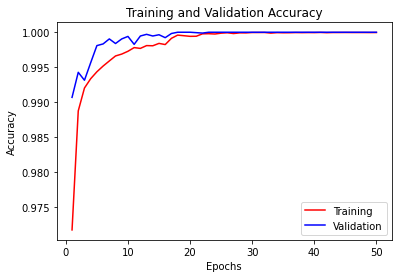

In [ ]:
hist = history.history
acc = hist['accuracy']
valAcc = hist['val_accuracy']
epochs = range(1, (len(hist['accuracy']) + 1))
plt.plot(epochs, acc, 'r', label='Training')
plt.plot(epochs, valAcc, 'b', label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [4]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model.png")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        3

Predict the test set

In [ ]:
y_pred_single = model.predict(x_test_single)
print(y_pred_single.shape)

(42114, 10)


Convert the single digits predictions into a single label (i.e. 1-5 digits, padded with 10s)

In [ ]:
y_pred=[]
pred_row=[]

#for every original test set image, create a list of predicted labels
for img_num in range(0, X_test.shape[0]):
  num_digits=0
  #for digits in image, append the predicted value to the list of predicted label
  for j in np.nonzero(np.array(test_img_num)==img_num)[0]:
      pred_row.append(np.argmax(y_pred_single[j]))
      num_digits+=1

  #fill in remaining labels with the value 10
  while (num_digits<5):
    pred_row.append(10)
    num_digits+=1
  y_pred.append(np.array(pred_row))
  pred_row=[]
  num_digits=0

y_pred=np.array(y_pred)

Save the results as a CSV

In [ ]:
import pandas as pd
predictions_concatenated=[]

#convert the predictions array into one number, a string
for i in y_pred:
  predictions_concatenated.append(''.join(map(str,i)))

df = pd.DataFrame(data={'Label': predictions_concatenated})
df.Label.astype("str")

#had a weird occurence where I had 17000 rows, with the last rows all being 1010101010
df=df[0:14000]
x=df.to_csv('/content/drive/MyDrive/MLP3/sample.csv',index_label='Id')
print(df)

           Label
0      910101010
1         017310
2          14083
3      010101010
4         467810
...          ...
13995  110101010
13996     604110
13997  310101010
13998     419710
13999      58309

[14000 rows x 1 columns]
